<a href="https://colab.research.google.com/github/Medvate/neural_network_clothing/blob/master/neural_network_clothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural network for recognition of the model clothing

##Настройка данных для обучения и тестирования
***Dataset:*** *Fashion MNIST*

*Code on* **bold text** [GitHub](https://github.com/Medvate/neural_network_clothing)

In [0]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

p.s. ***Автономная работа (+ ускорение):*** "Runtime" --> "Change runtime type" --> в "Hardware accelerator" выбрать "GPU"


**Загружаем наш dataset одежды:**

где *(x_train, y_train)* - набор данных для обучения,
*(x_test, y_test)* - набор данных для тестирования

Функция **load_data()** возвращает 4 *numpy.ndarray*:
1. *x_train* - содержит в себе 60.000 матриц 28x28 с числами от 0 до 255 (белый - градиент серого - черный) для обучения;
2. *y_train* - 60.000 ответов (цифра от 0 до 9) для проверки при обучении;
3. *x_test* - содержит в себе 10.000 матриц 28x28 с числами от 0 до 255 (белый - градиент серого - черный) для тестирования;
4. *y_test* - 10.000 ответов (цифра от 0 до 9) для проверки при тестирования.

*p.s.* **Матрица** - это ndarray, содержащий ndarray'и.

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Мы решаем **задачу классификации** на этом списке (такие типы одежды присутствуют в наборе):

In [0]:
classes = ['T-shirt/top', 'Trouser', 'Pullover',
           'Dress', 'Coat', 'Sandal', 'Shirt',
           'Sneaker', 'Bag', 'Ankle boot']

Давайте посмотрим на то, из чего состоит наш **dataset**:

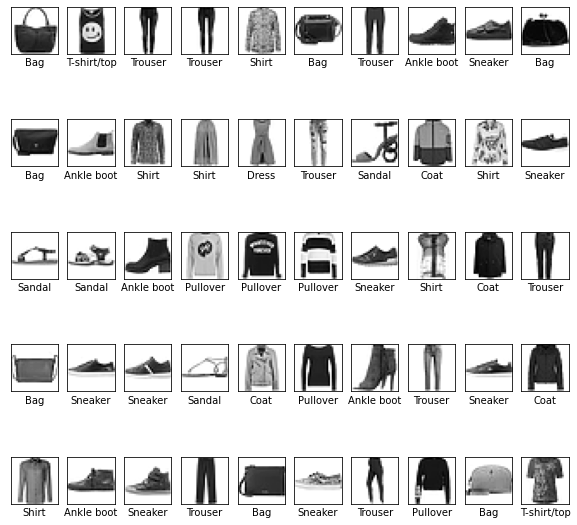

In [0]:
plt.figure(figsize=(10,10))
for i in range(100,150):
    plt.subplot(5,10,i-100+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(classes[y_train[i]])

Преобразуем картинки в плоский вектор (матрица 28x28 --> в массив 28*28=784):

In [0]:
x_train = x_train.reshape(60_000, 784)
x_test = x_test.reshape(10_000, 784)

**Нормализуем данные:** до этого в НС поступали бы числа от 0 до 255, а теперь - от 0 до 1. (Т.е. ***0<=pixel<=255*** --> ***0<=pixel<=1***, т.е. ***13*** --> ***0.050980392156862744*** (это 13/255))

Это используется только для алгоритмов оптимизации обучения НС.

*p.s.* запись вида: "**x /= 255**" выдает ошибку (почему - не ясно).

In [0]:
x_train = x_train / 255
x_test = x_test / 255

In [0]:
# До:
y_train[0]

9

Преобразование *номеров ответов* в массивы *bool-ответов*, т.е. **9** --> **[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]**:

In [0]:
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

In [0]:
# После:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

##Создание модели


**Создаем последовательную модель:**

In [0]:
model = Sequential()

**Добавляем входной слой** из 800 нейроном, 784 входов в каждый нейрон:

In [0]:
model.add(Dense(800, input_dim=784, activation="relu"))

*p.s.* **"Rectified Linear Unit (ReLu)":**


In [0]:
def ReLu(x):
    if x < 0:
        return 0
    else:
        return x

***ReLu*** - аналог более "мягкой" функции **F(x) = ln(1 + exp(x))**.

Нарисуем график:

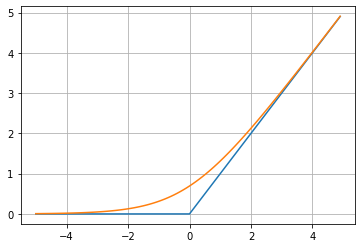

In [0]:
import math

arr_x = [i/10 for i in range(-50, 50)]
arr_relu = [ReLu(x) for x in arr_x]
arr_ln = [math.log(1 + math.exp(x)) for x in arr_x]

plt.grid()
plt.plot(arr_x, arr_relu, arr_x, arr_ln)

**Добавляем выходной слой** из 10 нейронов (как и ***типов одежды***):

In [0]:
model.add(Dense(10, activation="softmax"))

*p.s.* **SoftMAX** - это нормализованная экспоненциальная функция.
1. Используется для представления вероятности;
2. Сумма всех выходных значений нейронов равна 1.

**Вид:** S-образная.

**Компилируем модель:**

*p.s.* функция ошибки **"categorical_crossentropy"** хорошо подходит для задач классификаций, если классов больше двух.

In [0]:
model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

Посмотрим, как она устроена:

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 800)               628000    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


##Обучаем нейронную сеть

***Validation*** - кусок датасета, который используется для избежания **переобучения**. Это делается для сохранения обучающей способности НС (***Generalization ability***).

***Обучающая способность*** - это способность аналитической модели, построенной на основе машинного обучения (нейронной сети, дерева решений, карты Кохонена и др.) выдавать **правильные результаты** не только для примеров, участвовавших в процессе обучения, но и **для любых новых**, которые не участвовали в нем. 

In [0]:
model.fit(x_train, y_train, batch_size=200, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
240/240 [==============================] - 1s 5ms/step - loss: 1.1770 - accuracy: 0.6593 - val_loss: 0.8305 - val_accuracy: 0.7460
Epoch 2/100
240/240 [==============================] - 1s 4ms/step - loss: 0.7597 - accuracy: 0.7660 - val_loss: 0.6930 - val_accuracy: 0.7788
Epoch 3/100
240/240 [==============================] - 1s 4ms/step - loss: 0.6649 - accuracy: 0.7916 - val_loss: 0.6299 - val_accuracy: 0.7981
Epoch 4/100
240/240 [==============================] - 1s 4ms/step - loss: 0.6137 - accuracy: 0.8053 - val_loss: 0.5916 - val_accuracy: 0.8074
Epoch 5/100
240/240 [==============================] - 1s 4ms/step - loss: 0.5793 - accuracy: 0.8135 - val_loss: 0.5641 - val_accuracy: 0.8140
Epoch 6/100
240/240 [==============================] - 1s 4ms/step - loss: 0.5545 - accuracy: 0.8203 - val_loss: 0.5437 - val_accuracy: 0.8191
Epoch 7/100
240/240 [==============================] - 1s 4ms/step - loss: 0.5356 - accuracy: 0.8248 - val_loss: 0.5278 - val_accuracy: 0.8226

##Нарисуем нейронную сеть

*p.s.* если необходимо сохранить картинку в файл, просто добавить в функцию параметр ***to_file='plot_model.png'***

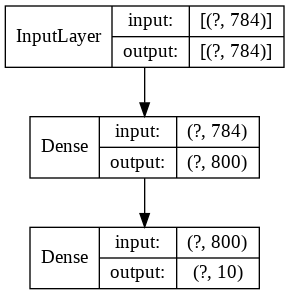

In [0]:
utils.plot_model(model, show_shapes=True, show_layer_names=False)

Метод **plot_model()** очень проблемный. Перед его использованием необходимо сделать следующее:

```bash
$ pip install pydot
$ pip install graphviz
$ sudo apt-get install graphviz
```

##Сохраняем нейронную сеть

А именно сохраняется следующее:
1. Архитектура НС
2. Веса обученной НС
3. Конфигурация обучения (функция ошибки, тип оптимизации)
4. Состояние оптимизации

In [0]:
model.save('fashion_mnist_dense.h5')

##Загружаем нейронную сеть из файла

Перед тем, как загрузить нашу нейронную сеть, удалим обученную, предварительно сохраненную НС:

In [0]:
del model

Подлючим необходимую функцию:

In [0]:
from tensorflow.keras.models import load_model

Теперь загрузим сеть из файла:

In [0]:
model = load_model('fashion_mnist_dense.h5')

Практическое применение (глупый тест):

In [0]:
predictions = model.predict(x_train)
print("Результаты по 1-ой картинке:", predictions[0])
print("Наш ответ:       ", classes[np.argmax(predictions[0])])
print("Правильный ответ:", classes[np.argmax(y_train[0])])

Результаты по 1-ой картинке: [1.0648039e-08 1.2923740e-10 3.8473227e-10 4.4401494e-10 1.2148983e-09
 2.9283218e-04 9.3752938e-08 1.4694183e-03 5.0971953e-06 9.9823254e-01]
Наш ответ:        Ankle boot
Правильный ответ: Ankle boot


##Проверяем нейросеть

Проверять мы будет на **тестовом куске датасета** (его нейросеть никогда не видела):

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.3800 - accuracy: 0.8665


Выведем результат проверки:

In [0]:
f"Доля верных ответов на тестовых данных: {round(scores[1] * 100, 4)}%"

'Доля верных ответов на тестовых данных: 86.65%'

##GitHub и свои картинки

###Подготовка

In [0]:
from tensorflow.keras.models import load_model
from google.colab import files
from IPython.display import Image
from tensorflow.keras.preprocessing import image
import numpy as np

Такие **типы одежды** присутствуют в наборе

In [0]:
classes = ['T-shirt/top', 'Trouser', 'Pullover',
           'Dress', 'Coat', 'Sandal', 'Shirt',
           'Sneaker', 'Bag', 'Ankle boot']

###Создаем модель

Скачиваем файл с обученной НС с **GitHub**:

*p.s.* Не допусти ошибки в ссылке в команде ***wget***:
1. Зайди на **GitHub** и найди файл, который нужно скачать;
2. Справа есть кнопка **Download**, нажми на неё **ПКМ** --> **"Копировать адрес ссылки"**;
3. Вставь эту ссылку в команду **wget**;
4. На всякий случай сравни **размеры** скачанного файла и файла на **GitHub**.

In [11]:
!wget https://github.com/Medvate/neural_network_clothing/raw/master/fashion_mnist_dense.h5 -O fashion_mnist_dense.h5

--2020-05-02 12:19:50--  https://github.com/Medvate/neural_network_clothing/raw/master/fashion_mnist_dense.h5
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Medvate/neural_network_clothing/master/fashion_mnist_dense.h5 [following]
--2020-05-02 12:19:50--  https://raw.githubusercontent.com/Medvate/neural_network_clothing/master/fashion_mnist_dense.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2561032 (2.4M) [application/octet-stream]
Saving to: ‘fashion_mnist_dense.h5’

fashion_mnist_dense 100%[===================>]   2.44M  --.-KB/s    in 0.07s   

2020-05-02 12:19:51 (33.4 MB/s) - ‘fashion_mni

In [14]:
!ls

fashion_mnist_dense.h5	sample_data


Создаем модель и выводим ее:

In [13]:
model = load_model('fashion_mnist_dense.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 800)               628000    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


###Загрузка своего фото

Можно загружать картинку прямо с компьютера:

f = files.upload()

А можно скачивать её из того же **GitHub**:

In [119]:
!wget https://github.com/Medvate/neural_network_clothing/raw/master/img_for_test/6.jpg -O 6.jpg

--2020-05-02 13:39:50--  https://github.com/Medvate/neural_network_clothing/raw/master/img_for_test/8.jpg
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Medvate/neural_network_clothing/master/img_for_test/8.jpg [following]
--2020-05-02 13:39:50--  https://raw.githubusercontent.com/Medvate/neural_network_clothing/master/img_for_test/8.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1353 (1.3K) [image/jpeg]
Saving to: ‘8.jpg’

8.jpg               100%[===================>]   1.32K  --.-KB/s    in 0s      

2020-05-02 13:39:50 (258 MB/s) - ‘8.jpg’ saved [1353/1353]



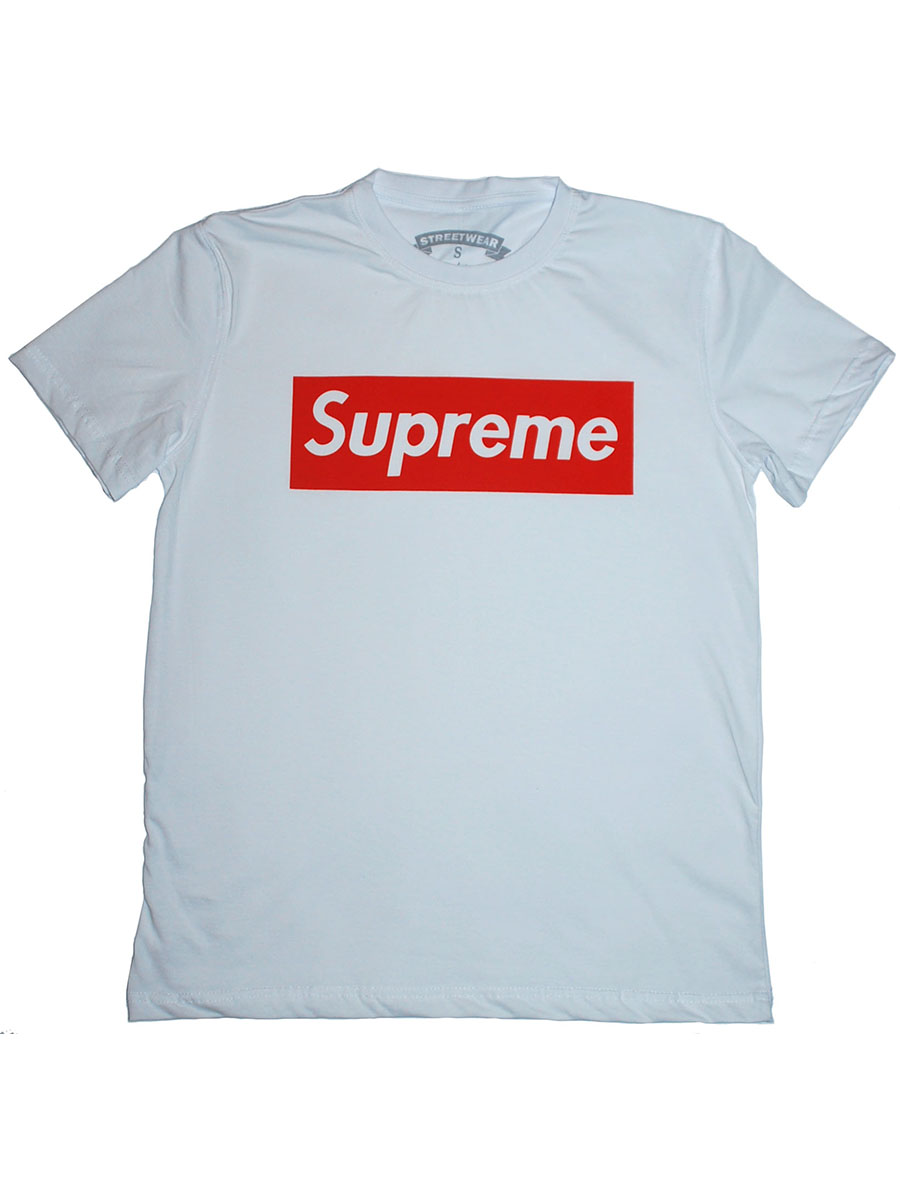

In [126]:
IMG_NAME = '6.jpg'

Image(IMG_NAME)

###Преобразуем фото в данные для НС

Преобразуем картинку маленькую (28x28) и черно-белую, затем в массив вида **[ [ [0.], ... , [255.] ], [ ... ], ... ,[ ... ] ]**: 

In [0]:
img = image.load_img(IMG_NAME, target_size=(28, 28), color_mode = "grayscale")

arr_pix = image.img_to_array(img)

Нарисуем маленькую картинку:

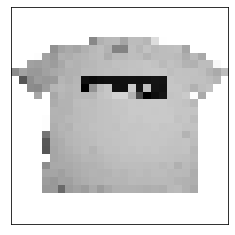

In [128]:
import matplotlib.pyplot as plt

arr_pix = arr_pix.reshape(28, 28)

plt.subplots()
plt.imshow(arr_pix, cmap=plt.cm.gist_gray)
plt.xticks([])
plt.yticks([])
plt.show()

Преобразуем данные изображения в понятные для нейросети:

In [0]:
# Меняем форму массива в плоский вектор
arr_pix = arr_pix.reshape(1, 784)
# Инвертируем изображение (особенность этого dataset'а)
arr_pix = 255 - arr_pix
# Нормализуем изображение
arr_pix /= 255

###Радуемся результату

Прогоним данные через нейросеть:

In [130]:
prediction = model.predict(arr_pix)
prediction

array([[3.0646768e-01, 2.3887850e-02, 1.8137707e-01, 5.6082527e-03,
        5.9975281e-02, 1.5603221e-02, 2.7034363e-01, 2.1666118e-04,
        1.3628131e-01, 2.3903363e-04]], dtype=float32)

Приведем результат к читаемому виду:

In [131]:
np.argmax(prediction)
print("Номер типа:   ", np.argmax(prediction) + 1)
print("Название типа:", classes[np.argmax(prediction)])

Номер типа:    1
Название типа: T-shirt/top
